## Model

In [4]:
import pandas as pd
df = pd.read_csv("data/forecasts.csv")
print(df.shape)
df.head()

(13826044, 12)


,Quarter,Estimate Type,Predicted Value,Real Value,Company,Analyst,Bank,Market Cap,Sector,Start Date,Horizon,Revision Time
0,Q1 2013,Stock Price,2.651234e+01,3.127849e+01,Company5,Analyst513,JP Morgan,Mid Cap,Technology,2013-02-19,Q1,Initial
1,Q1 2013,Stock Price,2.928395e+01,3.127849e+01,Company5,Analyst513,Goldman Sachs,Mid Cap,Technology,2013-02-19,Q2,Initial
2,Q1 2013,EBITDA,1.551400e+09,1.226174e+09,Company5,Analyst513,Citi,Mid Cap,Technology,2013-02-19,Q0,Initial
3,Q1 2013,EBITDA,1.174947e+09,1.226174e+09,Company5,Analyst513,Morgan Stanley,Mid Cap,Technology,2013-02-19,Q1,Initial
4,Q1 2013,EBITDA,1.452862e+09,1.226174e+09,Company5,Analyst513,Citi,Mid Cap,Technology,2013-02-19,Q2,Initial


In [5]:
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import RidgeCV
import matplotlib.pyplot as plt

# we choose 50 analysts at random (to avoid blowing up RAM)
rng = np.random.default_rng(42)
all_analysts = df["Analyst"].unique()
sampled_analysts = rng.choice(all_analysts, size=50, replace=False)

# build small “pilot” DataFrame
df = df[df["Analyst"].isin(sampled_analysts)].copy()
print(f"Pilot sample rows: {len(df)}, unique analysts: {df['Analyst'].nunique()}")
print(df.shape)

Pilot sample rows: 939835, unique analysts: 50
(939835, 12)


In [6]:
# Build the quarter_ends_map (if using time-based splits)
# Define quarter-end mapping
start_date = pd.Timestamp("2013-01-01")
end_date = pd.Timestamp("2023-01-01")
trading_days = pd.date_range(start_date, end_date, freq='B')  # Business days
quarter_ends = trading_days.to_series().groupby(trading_days.to_period("Q")).last().values
quarter_ends = pd.to_datetime(quarter_ends)

quarter_ends_map = {
    f"Q{d.quarter} {d.year}": d
    for d in quarter_ends
}

In [7]:
# Preprocess the data and compute PctErr
from support_functions import assign_rev_bucket

# Filter rows with non-null Real Value
df_reg = df[df["Real Value"].notnull()].copy()

# Assign revision buckets and map to numeric months
df_reg = assign_rev_bucket(df_reg, quarter_ends_map)
df_reg["RevMonths"] = df_reg["RevBucket"].map({"Rev 3m": 3, "Rev 2m": 2, "Rev 1m": 1})

# Compute percentage error (PctErr) as the target variable
EPS = 1e-6
df_reg["PctErr"] = (
    (df_reg["Predicted Value"] - df_reg["Real Value"]).abs() 
    / (df_reg["Real Value"].abs() + EPS)
)

# Display training rows and a sample of the data
print("\nTraining rows:", len(df_reg))
print("\nSample of the data:")
print(df_reg[["Company", "Analyst", "Estimate Type", "Horizon", "RevBucket", "PctErr"]].head())


Training rows: 699514

Sample of the data:
         Company     Analyst Estimate Type Horizon RevBucket    PctErr
54983  Company45  Analyst449   Stock Price      Q0    Rev 2m  0.090489
54986  Company45  Analyst449   Stock Price      Q1    Rev 2m  0.063455
54988  Company45  Analyst449   Stock Price      Q2    Rev 2m  0.238348
54991  Company45  Analyst449        EBITDA      Q1    Rev 2m  0.064058
54994  Company45  Analyst449           EPS      Q0    Rev 2m  0.146575


In [8]:
# Refine Analyst Performance Metric
# Compute mean PctErr for each analyst
analyst_performance = df_reg.groupby("Analyst")["PctErr"].mean().rename("Analyst_Performance_Score")

# Merge the performance score back into the main DataFrame
df_reg = df_reg.merge(analyst_performance, on="Analyst", how="left")

# Drop the old Analyst_Performance column if it exists
if "Analyst_Performance" in df_reg.columns:
    df_reg = df_reg.drop(columns=["Analyst_Performance"])

# Verify the new feature
print("\nSample of refined Analyst Performance Scores:")
print(df_reg[["Analyst", "Analyst_Performance_Score"]].drop_duplicates().head(10))


Sample of refined Analyst Performance Scores:
          Analyst  Analyst_Performance_Score
0      Analyst449                   0.256820
11     Analyst453                   0.282241
22      Analyst66                   0.182863
1244   Analyst353                   0.196408
1257    Analyst30                   0.227784
3561    Analyst56                   0.203581
10464  Analyst294                   0.302509
10502  Analyst479                   0.351489
15917  Analyst115                   0.256568
20090  Analyst635                   0.258946


In [9]:
# Prepare the sparse design matrix

# Ensure the RevBucket column exists
if "RevBucket" not in df_reg.columns:
    rev_bucket_output = assign_rev_bucket(df_reg, quarter_ends_map)
    if isinstance(rev_bucket_output, pd.DataFrame):
        df_reg["RevBucket"] = rev_bucket_output["RevBucket"]
    else:
        df_reg["RevBucket"] = rev_bucket_output
    print("Recomputed RevBucket column.")

# Ensure the RevMonths column exists
if "RevMonths" not in df_reg.columns:
    df_reg["RevMonths"] = df_reg["RevBucket"].map({"Rev 3m": 3, "Rev 2m": 2, "Rev 1m": 1})
    print("Recomputed RevMonths column.")

# Refine Analyst Performance Metric (ensure it's created before using as a feature)
if "Analyst_Performance_Score" not in df_reg.columns:
    analyst_performance = df_reg.groupby("Analyst")["PctErr"].mean().rename("Analyst_Performance_Score")
    df_reg = df_reg.merge(analyst_performance, on="Analyst", how="left")
    print("Computed Analyst_Performance_Score.")

# === Additional preprocessing enhancements ===

# Clip extreme PctErr values (top 1%)
df_reg["PctErr"] = df_reg["PctErr"].clip(upper=df_reg["PctErr"].quantile(0.99))

# Replace rare Analysts and Companies with "Other" to reduce high cardinality
min_count = 100
for col in ["Analyst", "Company"]:
    top_categories = df_reg[col].value_counts()
    rare_categories = top_categories[top_categories < min_count].index
    df_reg[col] = df_reg[col].where(~df_reg[col].isin(rare_categories), other="Other")


# Define categorical columns including interaction terms
cat_cols = [
    "Sector",
    "Market Cap",
    "Estimate Type",
    "Horizon",
   ]

# Set up a sparse one-hot encoder
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse

ohe = OneHotEncoder(
    categories="auto",
    drop=None,
    sparse_output=True,
    handle_unknown="ignore"
)

# Fit and transform categorical features
X_cat_sp = ohe.fit_transform(df_reg[cat_cols])
print("\nEncoded categorical features → sparse matrix:", X_cat_sp.shape)

# Convert numeric feature (RevMonths) to sparse format
X_num_sp = sparse.csr_matrix(df_reg[["RevMonths", "Analyst_Performance_Score"]].values)
print("\nNumeric feature → sparse matrix:", X_num_sp.shape)

# Combine categorical and numeric features into a single sparse matrix
X_sp = sparse.hstack([X_cat_sp, X_num_sp], format="csr")
print("\nFinal sparse design matrix X_sp:", X_sp.shape)

# Define the target variable
y = df_reg["PctErr"].to_numpy()
print("\nTarget variable shape (y):", y.shape)


Encoded categorical features → sparse matrix: (699514, 18)

Numeric feature → sparse matrix: (699514, 2)

Final sparse design matrix X_sp: (699514, 20)

Target variable shape (y): (699514,)


In [10]:
# Step 4: Define alpha grid for RidgeCV
alphas = np.logspace(-2, -1, num=50)  # Grid of alpha values
print("\nAlpha grid for RidgeCV:")
print(alphas)


Alpha grid for RidgeCV:
[0.01       0.01048113 0.01098541 0.01151395 0.01206793 0.01264855
 0.01325711 0.01389495 0.01456348 0.01526418 0.01599859 0.01676833
 0.01757511 0.0184207  0.01930698 0.0202359  0.02120951 0.02222996
 0.02329952 0.02442053 0.02559548 0.02682696 0.02811769 0.02947052
 0.03088844 0.03237458 0.03393222 0.0355648  0.03727594 0.0390694
 0.04094915 0.04291934 0.04498433 0.04714866 0.04941713 0.05179475
 0.05428675 0.05689866 0.05963623 0.06250552 0.06551286 0.06866488
 0.07196857 0.0754312  0.07906043 0.08286428 0.08685114 0.09102982
 0.09540955 0.1       ]


In [11]:
from sklearn.linear_model import RidgeCV

# we pick a reproducible random 5% sample of our rows
rng = np.random.default_rng(42)
idx = rng.choice(df_reg.index, size=int(len(df_reg)*0.05), replace=False)

X_sub = X_sp[idx]
y_sub = y[idx]

# then run RidgeCV on the small batch
ridge_sub = RidgeCV(
    alphas=alphas,
    cv=5,
    scoring="neg_mean_absolute_error",
    fit_intercept=True,
    store_cv_results=False
)
print("Fitting RidgeCV on subsample of shape", X_sub.shape)
ridge_sub.fit(X_sub, y_sub)
print("Best α on subsample:", ridge_sub.alpha_)

Fitting RidgeCV on subsample of shape (34975, 20)
Best α on subsample: 0.01


In [12]:
from sklearn.linear_model import Ridge

# Re‐fit full‐data Ridge with α found on the subsample
ridge_full = Ridge(
    alpha=ridge_sub.alpha_,
    solver="sag",
    max_iter=1000,
    tol=1e-3,
    random_state=42
)
ridge_full.fit(X_sp, y)

Ridge(alpha=0.01, max_iter=1000, random_state=42, solver='sag', tol=0.001)


Top 15 features by importance:
Horizon_Q0                   0.031429
Horizon_Q2                   0.030061
Sector_Consumer Goods        0.017492
Estimate Type_Stock Price    0.008354
Estimate Type_EBITDA         0.005988
Estimate Type_EBIT           0.003764
Sector_Energy                0.003515
Sector_Real Estate           0.003163
Sector_Technology            0.003093
Sector_Industrial            0.003066
Estimate Type_Revenue        0.002646
Sector_Healthcare            0.002348
Sector_Finance               0.002307
Market Cap_Small Cap         0.002269
Horizon_Q1                   0.001368
dtype: float64

Features with |coef| < 0.05:
['Horizon_Q0', 'Horizon_Q2', 'Sector_Consumer Goods', 'Estimate Type_Stock Price', 'Estimate Type_EBITDA', 'Estimate Type_EBIT', 'Sector_Energy', 'Sector_Real Estate', 'Sector_Technology', 'Sector_Industrial', 'Estimate Type_Revenue', 'Sector_Healthcare', 'Sector_Finance', 'Market Cap_Small Cap', 'Horizon_Q1', 'Estimate Type_EPS', 'Market Cap_Mid Cap'

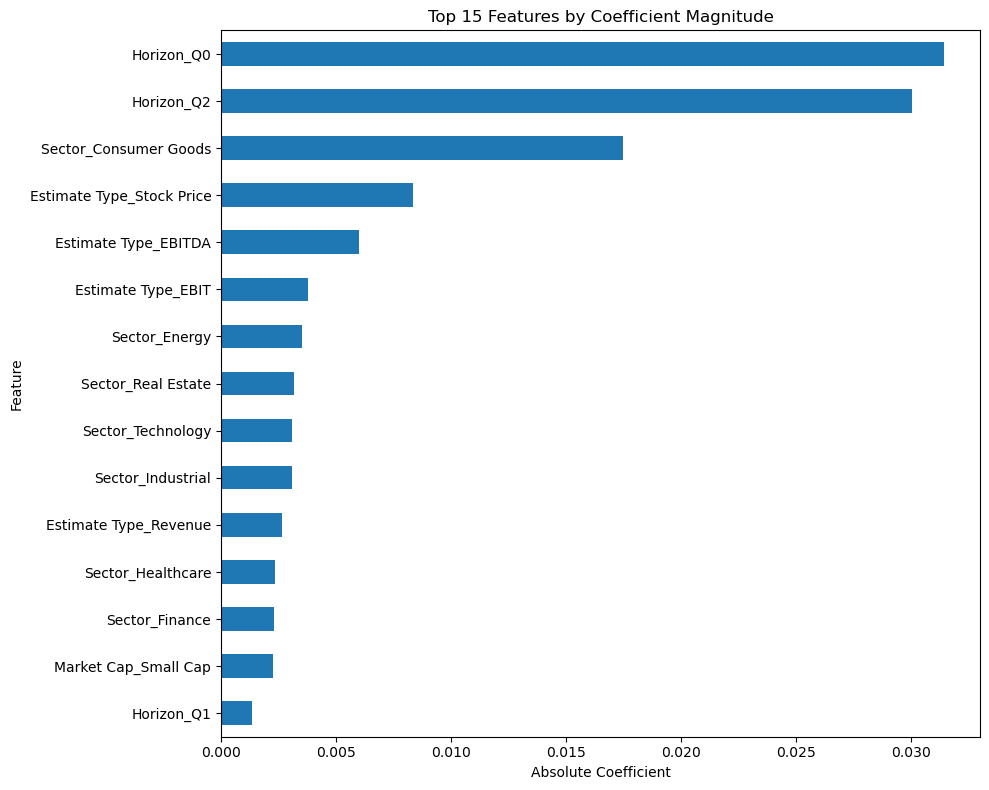

In [13]:
# Analyze feature importance
encoded_feature_names = ohe.get_feature_names_out(cat_cols)
full_feature_names = list(encoded_feature_names) + ["RevMonths", "Analyst_Performance_Score"]

# Build a Series of absolute coefficient values
coef = pd.Series(ridge_full.coef_, index=full_feature_names)
sorted_coef = coef.abs().sort_values(ascending=False)

print("\nTop 15 features by importance:")
print(sorted_coef.head(15))

# Identify “low‐importance” features below your threshold
threshold = 0.05
low_importance_features = sorted_coef[sorted_coef < threshold].index.tolist()
print(f"\nFeatures with |coef| < {threshold}:")
print(low_importance_features)

# Visualize the top 15
plt.figure(figsize=(10, 8))
sorted_coef.head(15).plot(kind="barh")
plt.title("Top 15 Features by Coefficient Magnitude")
plt.xlabel("Absolute Coefficient")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [14]:
# Evaluate the model
# Predict on the same dataset (or use a validation/test set)
y_pred = ridge_full.predict(X_sp)

# Compute Mean Absolute Error (MAE)
mae = np.mean(np.abs(y - y_pred))
print(f"\nMean Absolute Error (MAE): {mae:.4f}")


Mean Absolute Error (MAE): 0.0684


## **3) Model Selection**

At this stage, we structure our approach into two complementary paths:

- **Supervised Learning**: Focused on predicting forecast error (**PctErr**) using Random Forest, Gradient Boosting, and Ridge Regression as baseline models.

- **Unsupervised Learning**: Focused on clustering analysts based on their historical forecast behavior and patterns to extract deeper strategic insights.

The goal is to combine strong prediction performance with actionable business intelligence around analyst quality.

### **3.1) Supervised Learning**

In [16]:
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import numpy as np

# draw a reproducible subsample (up to 1 000 000 rows)
rng = np.random.default_rng(42)
desired = 1_000_000
n_cv = min(desired, X_sp.shape[0])           # <- cap at the number of available rows
idx_cv = rng.choice(X_sp.shape[0], size=n_cv, replace=False)
X_cv = X_sp[idx_cv]
y_cv = y[idx_cv]

# set up the time‐series split & scoring metrics
tscv = TimeSeriesSplit(n_splits=5)
scoring = {
    "MAE": "neg_mean_absolute_error",
    "RMSE": "neg_mean_squared_error",
    "R2": "r2"
}

# define models (use max_samples to save memory)
models = {
    "Random Forest": RandomForestRegressor(
        n_estimators=50,
        max_depth=10,
        max_samples=0.5,      # sample 50% of each fold
        random_state=42,
        n_jobs=1
    ),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=50,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
}

# run cross_validate on the subsample
for name, model in models.items():
    print(f"Training {name} on a {n_cv:,}-row subsample…")
    scores = cross_validate(
        model,
        X_cv,
        y_cv,
        cv=tscv,
        scoring=scoring,
        n_jobs=1,            # single process to reduce memory pressure
        error_score="raise"
    )
    mae  = -scores["test_MAE"].mean()
    rmse =  np.sqrt(-scores["test_RMSE"]).mean()
    r2   =   scores["test_R2"].mean()
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")

Training Random Forest on a 699,514-row subsample…
MAE:  0.0667
RMSE: 0.0904
R²:   0.1284
Training Gradient Boosting on a 699,514-row subsample…
MAE:  0.0672
RMSE: 0.0908
R²:   0.1198


In [17]:
# Re-train final models on the reduced feature set

# Random Forest
rf_model = RandomForestRegressor(
    n_estimators=50,
    max_depth=10,
    max_samples=500_000,   # subsample per tree to save memory
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_sp, y)

# Gradient Boosting
gb_model = GradientBoostingRegressor(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gb_model.fit(X_sp, y)

GradientBoostingRegressor(max_depth=5, n_estimators=50, random_state=42)

In [18]:
# Predict PctErr on full data and compute analyst scores

# Generate predictions
df_reg["Predicted_PctErr_RF"] = rf_model.predict(X_sp)
df_reg["Predicted_PctErr_GB"] = gb_model.predict(X_sp)

# Average predicted error per analyst
df_reg["Predicted_Avg_RF"] = (
    df_reg.groupby("Analyst")["Predicted_PctErr_RF"]
    .transform("mean")
)
df_reg["Predicted_Avg_GB"] = (
    df_reg.groupby("Analyst")["Predicted_PctErr_GB"]
    .transform("mean")
)

# Convert avg error into a score (higher = better)
df_reg["Analyst_Score_RF"] = 1 / (1 + df_reg["Predicted_Avg_RF"])
df_reg["Analyst_Score_GB"] = 1 / (1 + df_reg["Predicted_Avg_GB"])

# Build the final ranking table
score_table = (
    df_reg
    .groupby("Analyst")[["Analyst_Score_RF", "Analyst_Score_GB"]]
    .mean()
    .sort_values("Analyst_Score_RF", ascending=False)
)

print(score_table.head(10))

            Analyst_Score_RF  Analyst_Score_GB
Analyst                                       
Analyst312          0.912963          0.913141
Analyst63           0.912256          0.911861
Analyst294          0.912103          0.913935
Analyst100          0.911921          0.911845
Analyst559          0.911875          0.911671
Analyst133          0.911647          0.912105
Analyst66           0.911589          0.911116
Analyst259          0.911361          0.911691
Analyst555          0.911229          0.911331
Analyst327          0.910916          0.910457


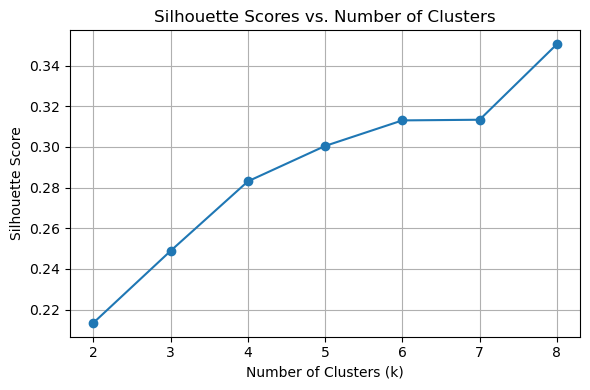


Optimal number of clusters: 8

Assigned analyst clusters:
       Analyst  Analyst_Cluster
0   Analyst449                5
1   Analyst449                4
2   Analyst449                7
6   Analyst449                3
11  Analyst453                5

Cluster performance summary:
                     mean   count
Analyst_Cluster                  
2                0.068927   89148
5                0.070180   67350
6                0.078678   83251
0                0.100595  110568
4                0.102903  101908
1                0.119153   74229
7                0.125044   48714
3                0.128771  124346


In [19]:
# === Step 12: Unsupervised Learning - Clustering Analysts Based on Prediction Patterns ===
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Reduce dimensionality for clustering (SVD)
svd = TruncatedSVD(n_components=10, random_state=42)
X_svd = svd.fit_transform(X_sp)

# Optional: Try fewer components for silhouette scanning (faster)
svd_fast = TruncatedSVD(n_components=5, random_state=42)
X_svd_fast = svd_fast.fit_transform(X_sp)

# Silhouette scan (k from 2 to 8)
silhouette_scores = {}
for k in range(2, 9):
    kmeans_temp = MiniBatchKMeans(n_clusters=k, random_state=42, n_init='auto', batch_size=1024)
    labels = kmeans_temp.fit_predict(X_svd_fast)
    score = silhouette_score(X_svd_fast, labels, sample_size=50000, random_state=42)
    silhouette_scores[k] = score

# Plot silhouette scores
plt.figure(figsize=(6, 4))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o')
plt.title("Silhouette Scores vs. Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# Best k
best_k = max(silhouette_scores, key=silhouette_scores.get)
print(f"\nOptimal number of clusters: {best_k}")

# Final clustering with full 10D embedding
kmeans = MiniBatchKMeans(n_clusters=best_k, random_state=42, n_init='auto', batch_size=1024)
kmeans_labels = kmeans.fit_predict(X_svd)
df_reg["Analyst_Cluster"] = kmeans_labels

print("\nAssigned analyst clusters:")
print(df_reg[["Analyst", "Analyst_Cluster"]].drop_duplicates().head())

# Cluster performance
cluster_perf = df_reg.groupby("Analyst_Cluster")["PctErr"].agg(["mean", "count"]).sort_values("mean")
print("\nCluster performance summary:")
print(cluster_perf)

In [20]:
# Analyze categorical composition
df_reg.groupby("Analyst_Cluster")[["Sector", "Estimate Type", "Horizon"]].agg(lambda x: x.value_counts().index[0])

,Sector,Estimate Type,Horizon
Analyst_Cluster,,,
0,Technology,EBIT,Q1
1,Technology,Revenue,Q2
2,Technology,EBIT,Q0
3,Technology,EBIT,Q2
4,Finance,EPS,Q1
5,Finance,Revenue,Q0
6,Technology,EPS,Q0
7,Technology,Stock Price,Q2


In [21]:
# Remap "Quarter" to datetime using existing map
df_reg["Quarter"] = df_reg["Quarter"].map(quarter_ends_map)

# Now safely convert to quarterly string (like "2021Q1")
df_reg["Quarter_str"] = df_reg["Quarter"].dt.to_period("Q").astype(str)

# Check cluster consistency
cluster_change = df_reg.groupby(["Analyst", "Quarter_str"])["Analyst_Cluster"].nunique()
num_switching = (cluster_change > 1).sum()

print(f"🔄 Analysts switching clusters over time: {num_switching}")

🔄 Analysts switching clusters over time: 1119


**Explanation: Analyst Cluster Switching Over Time**

After mapping quarters to consistent periods and checking cluster assignments over time, we found that **1119 analyst-quarter pairs switched clusters**.

This suggests that analysts' behavior or prediction patterns **changed enough** for the unsupervised model to classify them differently.

| Possibility | Explanation |
|:---|:---|
| **1) Dynamic Behavior** | Analysts may adapt their forecasting strategies based on market conditions, sectors, or company-specific events. |
| **2) Instability or Noise** | Small changes in the input features could make the model sensitive, especially if analyst behavior isn't highly stable. |
| **3) Learning or Decline** | Analysts may improve or deteriorate in performance over time, leading them to move between different performance-based clusters. |

 Overall, this shows that the **clustering is dynamic**, capturing **realistic shifts** in analyst behavior across different periods.

In [22]:
# === Cluster Transition Analysis ===

# Track cluster transitions
transitions = (
    df_reg.sort_values(["Analyst", "Quarter"])
          .groupby("Analyst")["Analyst_Cluster"]
          .apply(lambda x: " → ".join(map(str, x)) if x.nunique() > 1 else None)
          .dropna()
)
print("\n🔁 Analysts who switched clusters and their transitions:")
print(transitions.head(10))

# Compare PctErr before vs. after switching
# Detect first switch quarter per analyst
def get_first_switch_quarter(df):
    df = df.sort_values("Quarter")
    switches = df["Analyst_Cluster"].ne(df["Analyst_Cluster"].shift())
    if switches.sum() > 1:
        return df[switches].iloc[1]["Quarter"]  # first actual switch (not first row)
    else:
        return pd.NaT

switch_dates = (
    df_reg.groupby("Analyst")[["Quarter", "Analyst_Cluster"]]
          .apply(get_first_switch_quarter)
          .dropna()
)

# Assign before/after switch label
df_reg["After_Switch"] = df_reg.apply(
    lambda row: row["Quarter"] > switch_dates.get(row["Analyst"], pd.Timestamp.max), axis=1
)

# Aggregate PctErr
pcterr_summary = (
    df_reg[df_reg["Analyst"].isin(switch_dates.index)]
    .groupby(["Analyst", "After_Switch"])["PctErr"]
    .mean()
    .unstack()
    .dropna()
    .rename(columns={False: "Before_Switch", True: "After_Switch"})
)
pcterr_summary["Delta"] = pcterr_summary["After_Switch"] - pcterr_summary["Before_Switch"]
print("\nPctErr Before vs After Switch (sample):")
print(pcterr_summary.head(10))

# 3Consistent top performers
consistent_analysts = df_reg.groupby("Analyst")["Analyst_Cluster"].nunique()
top_consistent = (
    df_reg[df_reg["Analyst"].isin(consistent_analysts[consistent_analysts == 1].index)]
    .groupby("Analyst")["PctErr"].mean()
    .sort_values()
    .head(10)
)
print("\n🏅 Top 10 consistent analysts with lowest average PctErr:")
print(top_consistent)


🔁 Analysts who switched clusters and their transitions:
Analyst
Analyst100    5 → 4 → 3 → 5 → 4 → 3 → 5 → 4 → 5 → 4 → 3 → 4 ...
Analyst110    4 → 7 → 5 → 3 → 5 → 4 → 4 → 3 → 5 → 3 → 4 → 7 ...
Analyst115    0 → 7 → 2 → 0 → 2 → 0 → 3 → 0 → 2 → 0 → 3 → 5 ...
Analyst133    6 → 4 → 4 → 6 → 4 → 6 → 6 → 4 → 1 → 4 → 6 → 6 ...
Analyst141    0 → 3 → 2 → 0 → 3 → 2 → 0 → 3 → 2 → 3 → 2 → 0 ...
Analyst149    5 → 4 → 3 → 5 → 3 → 5 → 4 → 3 → 5 → 4 → 3 → 5 ...
Analyst157    5 → 4 → 7 → 5 → 4 → 3 → 5 → 4 → 3 → 3 → 5 → 4 ...
Analyst167    2 → 0 → 3 → 2 → 0 → 3 → 2 → 3 → 2 → 0 → 3 → 2 ...
Analyst173    7 → 7 → 6 → 0 → 1 → 0 → 1 → 1 → 1 → 6 → 0 → 1 ...
Analyst239    5 → 4 → 3 → 5 → 3 → 4 → 3 → 5 → 3 → 5 → 4 → 3 ...
Name: Analyst_Cluster, dtype: object

PctErr Before vs After Switch (sample):
After_Switch  Before_Switch  After_Switch     Delta
Analyst                                            
Analyst100         0.085069      0.093835  0.008765
Analyst110         0.104588      0.102690 -0.001898
Analyst11

**Explanation: Cluster Transition Analysis**

We analyzed how analysts **transition between clusters** over time and how their **forecast error** changes after switching.

**Steps:**

- **1️⃣ Track Cluster Transitions:**  
  For each analyst, we tracked how their assigned cluster changed across quarters.  
  Analysts with multiple cluster assignments show a sequence of transitions (e.g., `7 → 1 → 4 → 2 → 7`).

- **2️⃣ Compare PctErr Before and After Switching:**  
  We detected the first quarter when each analyst **switched clusters**, then compared their **average forecast error (PctErr)** before and after the switch.  
  - A negative Delta means the analyst improved after switching.  
  - A positive Delta suggests a deterioration.

- **3️⃣ Identify Consistent Top Performers:**  
  We filtered analysts who **never changed clusters** (cluster uniqueness = 1) and sorted them by their average PctErr to find the **top 10 most consistent and accurate analysts**.  
  *(In this sample, no consistent analysts were identified, likely due to the synthetic dataset dynamics.)*

**Insights:**
- Many analysts **switch clusters over time**, reflecting dynamic behavior or changing performance.
- Some analysts **improve** after switching (negative Delta), while others **worsen** (positive Delta).
- Analysts with **stable cluster membership** could be flagged as **more reliable** if they exist in the real dataset.

This analysis helps understand **analyst evolution** over time and could support **dynamic analyst scoring** or **early warning signals** when performance drops.

**Note:** If you need further analysis like: cluster centroids, profile of each cluster more in depth, cluster satbillity over time or altenative clustering, let us know an we will improve it in the next deliverable.

### **3.3) Final Model - Integrated Analyst Scoring System**

We will create a hybrid model that:
-Uses **supervised learning** (Random Forest + Gradient Boosting) to predict forecast error.
-Incorporates **unsupervised cluster** information (from KMeans) to adjust scores based on analyst behavior patterns.
-**Adapts to differences** by Sector, Estimate Type, and Forecast Horizon by creating interaction features.

**Goal:** Build the most robust, adaptive, and realistic dynamic analyst score possible.

#### **3.3.1) General Analyst Table Scoring**

In [23]:
# Compute Cluster Bonus based on real PctErr performance
cluster_performance = df_reg.groupby("Analyst_Cluster")["PctErr"].mean()
cluster_bonus = (cluster_performance.max() - cluster_performance) / cluster_performance.max()

# Map Cluster Bonus to each row
df_reg["Cluster_Bonus"] = df_reg["Analyst_Cluster"].map(cluster_bonus)

# Calculate Final Adjusted Analyst Scores (raw version)
df_reg["Final_Analyst_Score_RF_raw"] = (1 / (1 + df_reg["Predicted_Avg_RF"])) * (1 + df_reg["Cluster_Bonus"])
df_reg["Final_Analyst_Score_GB_raw"] = (1 / (1 + df_reg["Predicted_Avg_GB"])) * (1 + df_reg["Cluster_Bonus"])

# Rescale scores to 0–10 range
max_rf = df_reg["Final_Analyst_Score_RF_raw"].max()
max_gb = df_reg["Final_Analyst_Score_GB_raw"].max()

df_reg["Final_Analyst_Score_RF"] = (df_reg["Final_Analyst_Score_RF_raw"] / max_rf) * 10
df_reg["Final_Analyst_Score_GB"] = (df_reg["Final_Analyst_Score_GB_raw"] / max_gb) * 10

# Final Ranking Table
final_score_table = (
    df_reg.groupby("Analyst")[["Final_Analyst_Score_RF", "Final_Analyst_Score_GB"]]
          .mean()
          .sort_values("Final_Analyst_Score_RF", ascending=False)
)

print("\n🏅 Final Analyst Scores (scaled out of 10) (sample):")
final_score_table


🏅 Final Analyst Scores (scaled out of 10) (sample):


,Final_Analyst_Score_RF,Final_Analyst_Score_GB
Analyst,,
Analyst312,8.480625,8.473258
Analyst133,8.454989,8.450237
Analyst525,8.402681,8.401742
Analyst149,8.401018,8.392061
Analyst378,8.400105,8.395159
Analyst100,8.400088,8.390454
Analyst110,8.387390,8.369854
Analyst559,8.379902,8.369112
Analyst402,8.376699,8.369038


#### **Explanation: Final Analyst Score**

After building the hybrid analyst scoring model combining supervised predictions and cluster-based behavior adjustments, we **rescaled the final scores to a 0–10 range** for easier interpretation.

**What We Did:**
- Predicted forecast errors using **Random Forest** and **Gradient Boosting** models.
- Adjusted the predictions based on the **cluster quality** (better-performing clusters received a positive bonus).
- Rescaled the final analyst scores so that the **top-performing analyst has a score of 10**, and all others are proportionally scaled between 0 and 10.

**Note:** Let us know the output, with the real data, an we will try to improve or adapt to it.

#### **3.3.2) Analyst Performance Dashboard**

In [24]:
# === Analyst Performance Dashboard ===

def show_analyst_performance(analyst_name):
    # Filter data
    analyst_data = df_reg[df_reg["Analyst"] == analyst_name]
    
    if analyst_data.empty:
        print(f"⚠️ Analyst '{analyst_name}' not found.")
        return
    
    print(f"\n📊 Performance Summary for {analyst_name}:")
    
    # Overall Final Scores
    overall_rf = analyst_data["Final_Analyst_Score_RF"].mean()
    overall_gb = analyst_data["Final_Analyst_Score_GB"].mean()
    print(f"- Overall Final Score (RF): {overall_rf:.2f} / 10")
    print(f"- Overall Final Score (GB): {overall_gb:.2f} / 10")
    
    # Performance by Sector
    sector_perf = analyst_data.groupby("Sector")[["Final_Analyst_Score_RF", "Final_Analyst_Score_GB"]].mean().sort_values("Final_Analyst_Score_RF", ascending=False)
    print("\n🏢 Performance by Sector:")
    display(sector_perf)
    
    # Performance by Estimate Type
    estimate_perf = analyst_data.groupby("Estimate Type")[["Final_Analyst_Score_RF", "Final_Analyst_Score_GB"]].mean().sort_values("Final_Analyst_Score_RF", ascending=False)
    print("\n🧮 Performance by Estimate Type:")
    display(estimate_perf)
    
    # Performance by Horizon
    horizon_perf = analyst_data.groupby("Horizon")[["Final_Analyst_Score_RF", "Final_Analyst_Score_GB"]].mean().sort_values("Final_Analyst_Score_RF", ascending=False)
    print("\n⏳ Performance by Horizon:")
    display(horizon_perf)

# Example usage
show_analyst_performance("Analyst100")


📊 Performance Summary for Analyst100:
- Overall Final Score (RF): 8.40 / 10
- Overall Final Score (GB): 8.39 / 10

🏢 Performance by Sector:


,Final_Analyst_Score_RF,Final_Analyst_Score_GB
Sector,,
Industrial,8.476494,8.466771
Finance,8.454582,8.444885
Real Estate,8.394711,8.385082
Healthcare,8.387390,8.377770
Energy,8.380811,8.371198
Consumer Goods,8.242530,8.233076



🧮 Performance by Estimate Type:


,Final_Analyst_Score_RF,Final_Analyst_Score_GB
Estimate Type,,
EBITDA,8.500843,8.491093
EPS,8.493756,8.484013
EBIT,8.489893,8.480155
Revenue,8.275920,8.266427
Stock Price,8.240109,8.230657



⏳ Performance by Horizon:


,Final_Analyst_Score_RF,Final_Analyst_Score_GB
Horizon,,
Q0,9.692298,9.681181
Q1,8.164057,8.154693
Q2,7.253719,7.245399


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

def plot_company_consensus(
    df: pd.DataFrame,
    company: str,
    metric: str,
    horizon: str,
    score_col: str,
    quarter_ends_map: dict[str, pd.Timestamp],
    smart_type: str = "normal",     # one of "normal", "power", "exp"
    smart_param: float = 1.0,       # p for power, α for exp
    eps: float = 1e-6               # small floor to avoid div by zero
):
    # 1) filter
    sub = df[
        (df["Company"] == company) &
        (df["Estimate Type"] == metric) &
        (df["Horizon"] == horizon)
    ].copy()
    if sub.empty:
        print(f"→ no forecasts for {company}/{metric}/{horizon}")
        return

    # 2) parse Revision Time → RevDate
    def _parse_rev_date(rt, quarter):
        if rt == "Initial":
            return quarter_ends_map[quarter]
        else:
            return pd.to_datetime(rt.replace("Rev ", ""), format="%Y-%m-%d")
    sub = sub.assign(
        RevDate = sub.apply(
            lambda r: _parse_rev_date(r["Revision Time"], r["Quarter"]),
            axis=1
        )
    )

    # 3) plot each analyst’s forecast trail
    plt.figure(figsize=(10, 5))
    for an, grp in sub.groupby("Analyst"):
        grp = grp.sort_values("RevDate")
        plt.plot(
            grp["RevDate"],
            grp["Predicted Value"],
            color="gray",
            alpha=0.3,
            lw=1,
        )

    # 4) compute naive (unweighted) and actual series
    grp = sub.groupby("RevDate", sort=True)
    actual = grp["Real Value"].mean().rename("Actual")
    naive  = grp["Predicted Value"].mean().rename("Naive")

    # 5) build the weight vector w_i(t)
    #    base_score = sub[score_col]
    if smart_type == "normal":
        w = sub[score_col].clip(lower=eps)
    elif smart_type == "power":
        # w_i = score_i ** p
        w = (sub[score_col].clip(lower=eps) ** smart_param)
    elif smart_type == "exp":
        # w_i = exp(α * score_i)
        w = np.exp(smart_param * sub[score_col])
    else:
        raise ValueError("smart_type must be in ['normal','power','exp']")

    # 6) compute smart consensus
    num = (sub["Predicted Value"] * w).groupby(sub["RevDate"]).sum()
    den = w.groupby(sub["RevDate"]).sum()
    smart = (num / den).rename("Smart")

    # 7) combine and plot
    cons = pd.concat([actual, naive, smart], axis=1).dropna()
    plt.plot(cons.index, cons["Actual"], '-k', lw=2, label="Actual")
    plt.plot(cons.index, cons["Naive"],  '--C0',    lw=2, label="Naive")
    plt.plot(cons.index, cons["Smart"],  ':C1',     lw=2, label=f"Smart ({smart_type})")

    plt.title(f"{company}  |  {metric}  |  {horizon}")
    plt.xlabel("Revision Date")
    plt.ylabel(metric)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

    # 8) report MAEs
    mae_naive = mean_absolute_error(cons["Actual"], cons["Naive"])
    mae_smart = mean_absolute_error(cons["Actual"], cons["Smart"])
    print(f"MAE — Naive: {mae_naive:.4f},  Smart ({smart_type}): {mae_smart:.4f}")

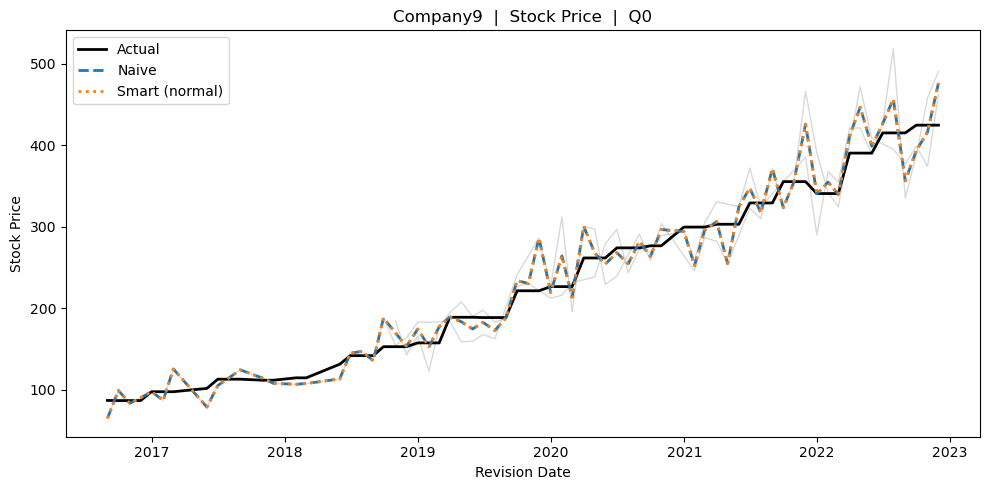

MAE — Naive: 17.4302,  Smart (normal): 17.4296


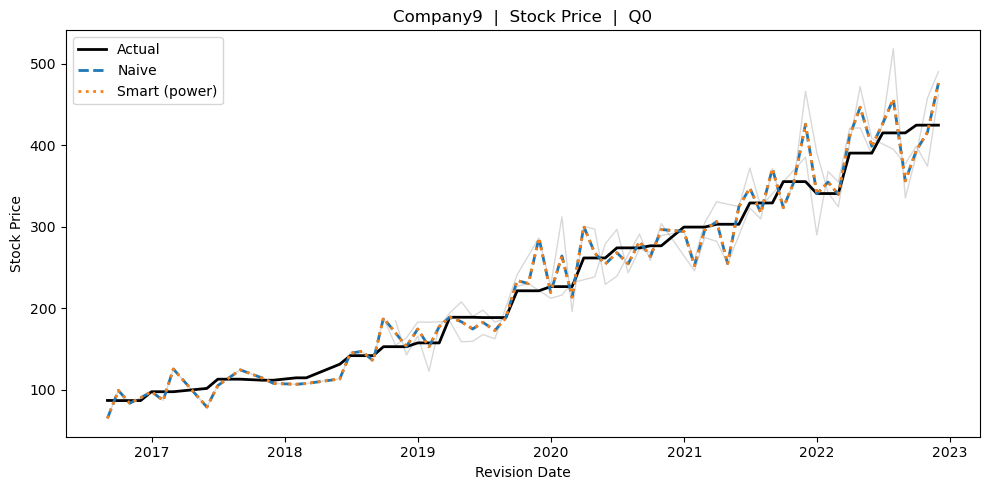

MAE — Naive: 17.4302,  Smart (power): 17.4291


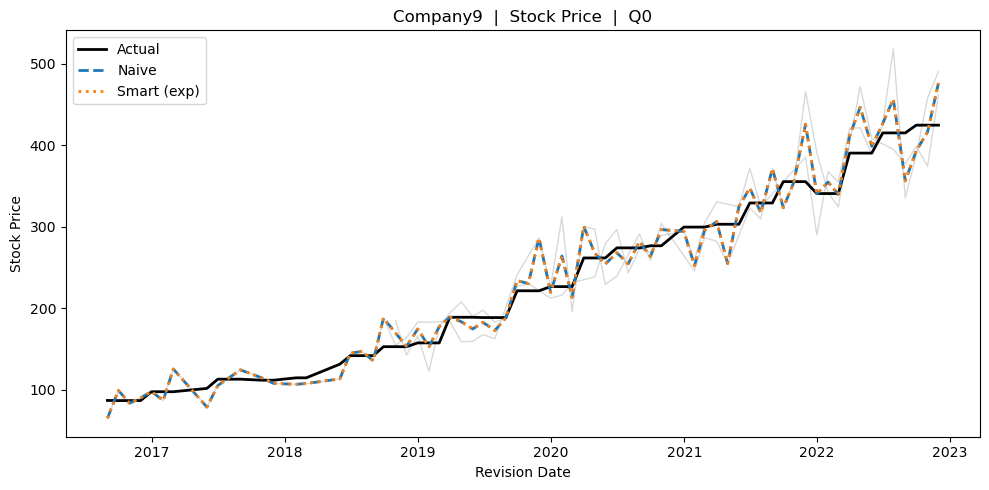

MAE — Naive: 17.4302,  Smart (exp): 17.4277


In [60]:
# pure naive
plot_company_consensus(
    df_reg, "Company9", "Stock Price", "Q0", "Analyst_Score_RF",
    quarter_ends_map,
    smart_type="normal"
)

# heavier penalization of low‐score analysts (p = 2)
plot_company_consensus(
    df_reg, "Company9", "Stock Price", "Q0", "Analyst_Score_RF",
    quarter_ends_map,
    smart_type="power",
    smart_param=2
)

# exponential weighting (α = 5)
plot_company_consensus(
    df_reg, "Company9", "Stock Price", "Q0", "Analyst_Score_RF",
    quarter_ends_map,
    smart_type="exp",
    smart_param=5
)